# Handwritten Text Recognition

## 1. Import Important packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import mxnet as mx
from mxnet import gluon

In [2]:
from utilities.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from utilities.expand_bounding_box import expand_bounding_box
from utilities.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from utilities.word_to_line import sort_bbs_line_by_line, crop_line_images
from utilities.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from utilities.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
from utilities.beam_search import ctcBeamSearch

In [3]:
ctx=mx.cpu()

## 2. Create test dataset

In [4]:
test_ds = IAMDataset("form_original", train=False) #stores as arrays along with output text

Convert subject list


## 3. Plot Original Image

In [5]:
print(len(test_ds))

232


In [27]:
#Sets 4 images
figs_to_plot = 4
images = []
text = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)
    text.append(_)

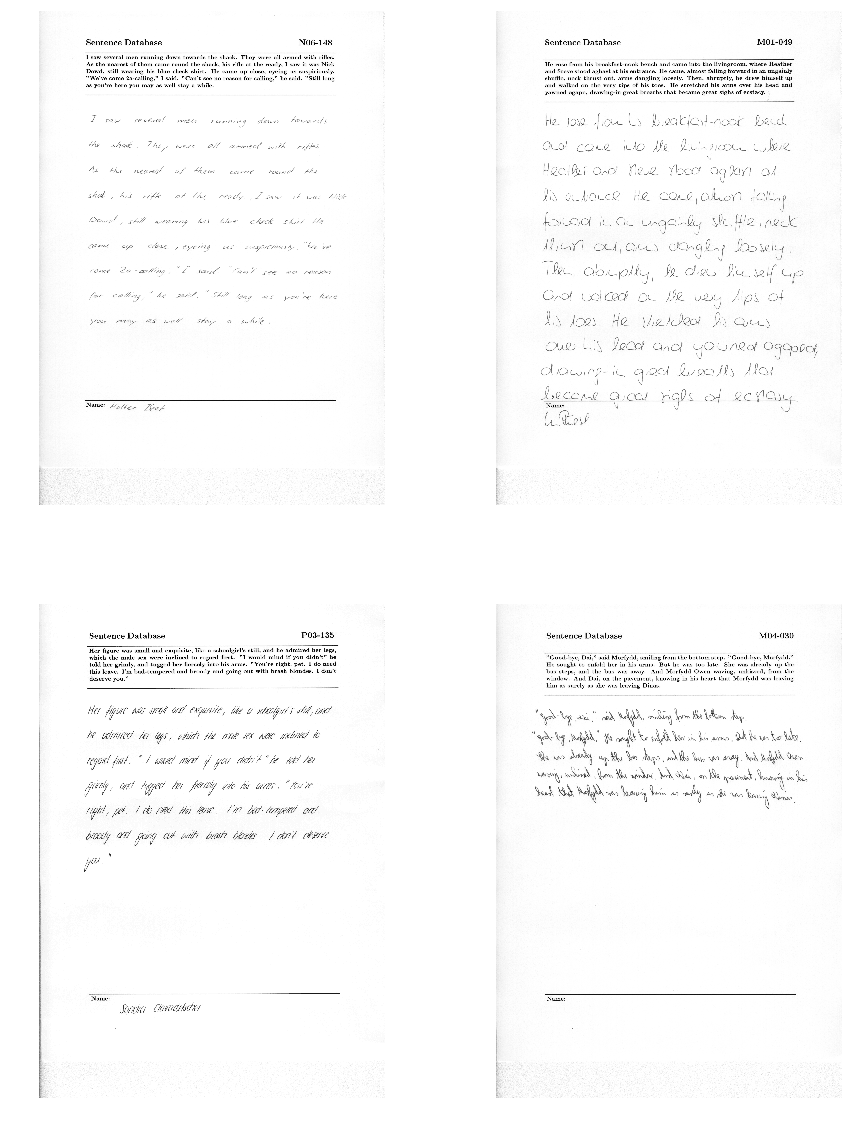

In [28]:
#shows 4 images
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## 4. Load Paragraph Segmentation Model

In [29]:
sym = mx.sym.load_json(open('model_export/cnn_mse_final-symbol.json', 'r').read())
paragraph_segmentation_net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var('data'))
paragraph_segmentation_net.load_parameters('model_export/cnn_mse_final-0093.params', ctx=ctx)

In [30]:
def paragraph_segmentation_transform(image, image_size):
    '''
    Function used for inference to resize the image for paragraph segmentation
    '''
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

## 5. Run Paragraph Segmentation on test images

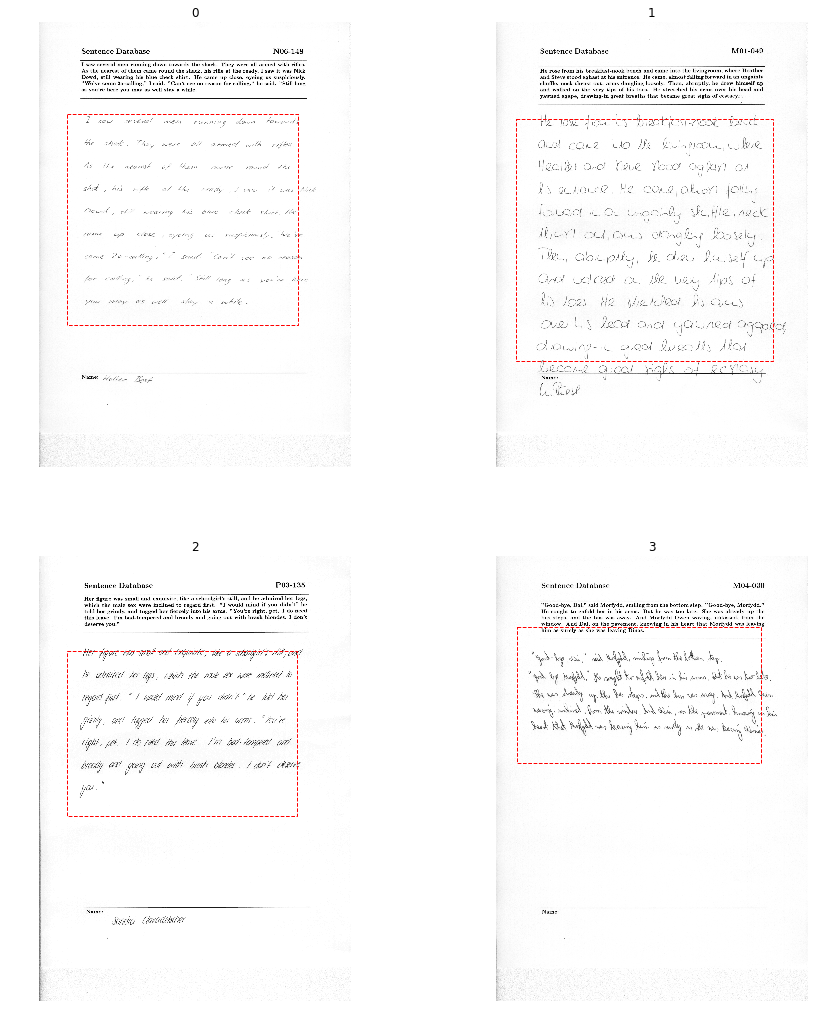

In [31]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## 6. Crop form to paragraph

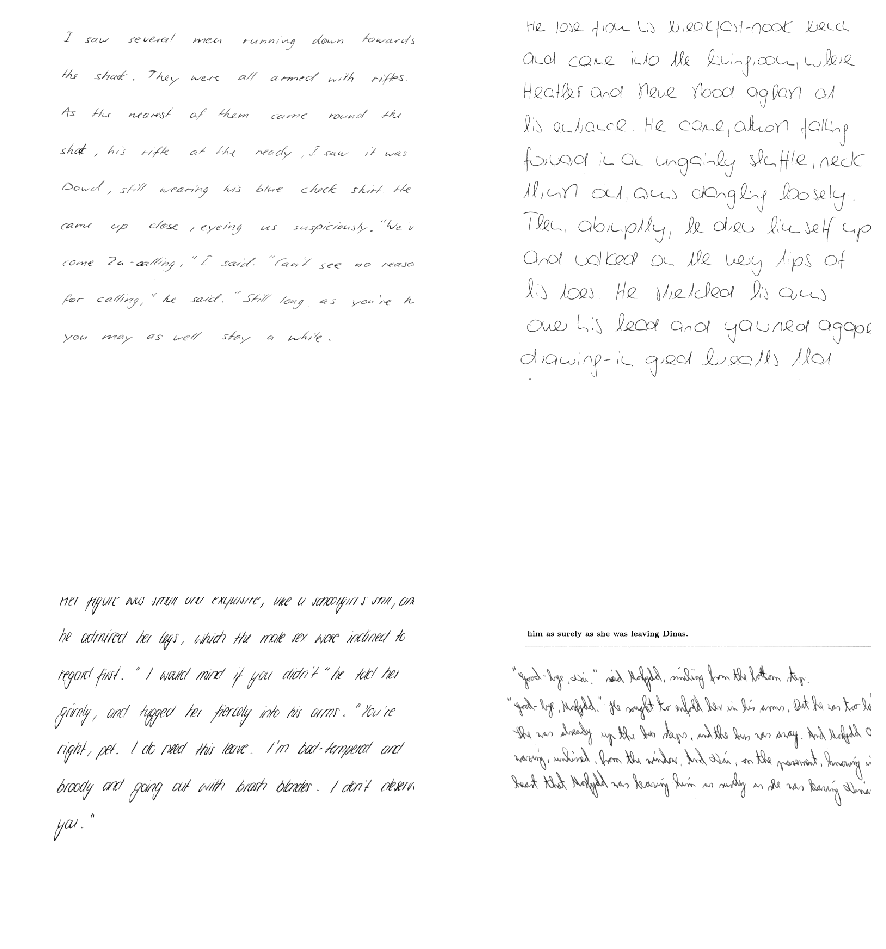

In [32]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    if(i==0):
        final_image=image

# 7. Load Word Segmentation model

In [33]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

# 8. Run Word Segmentation on test images

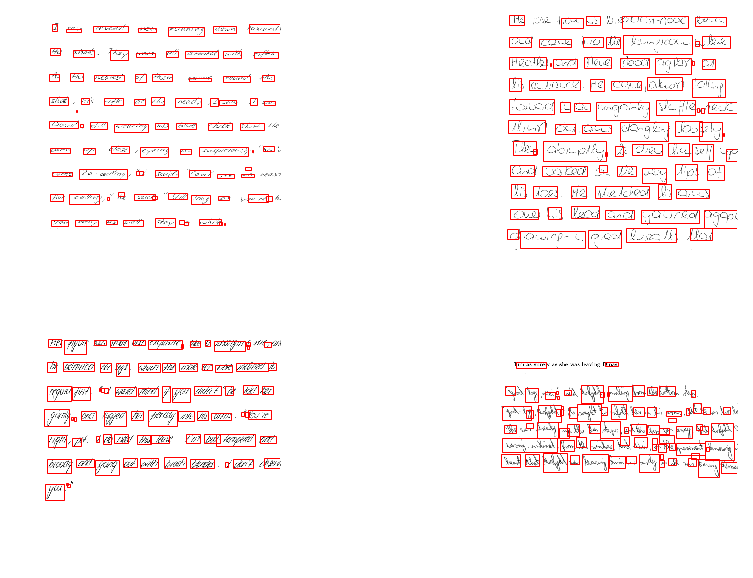

In [34]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

# 9. Convert to Line Segmentation

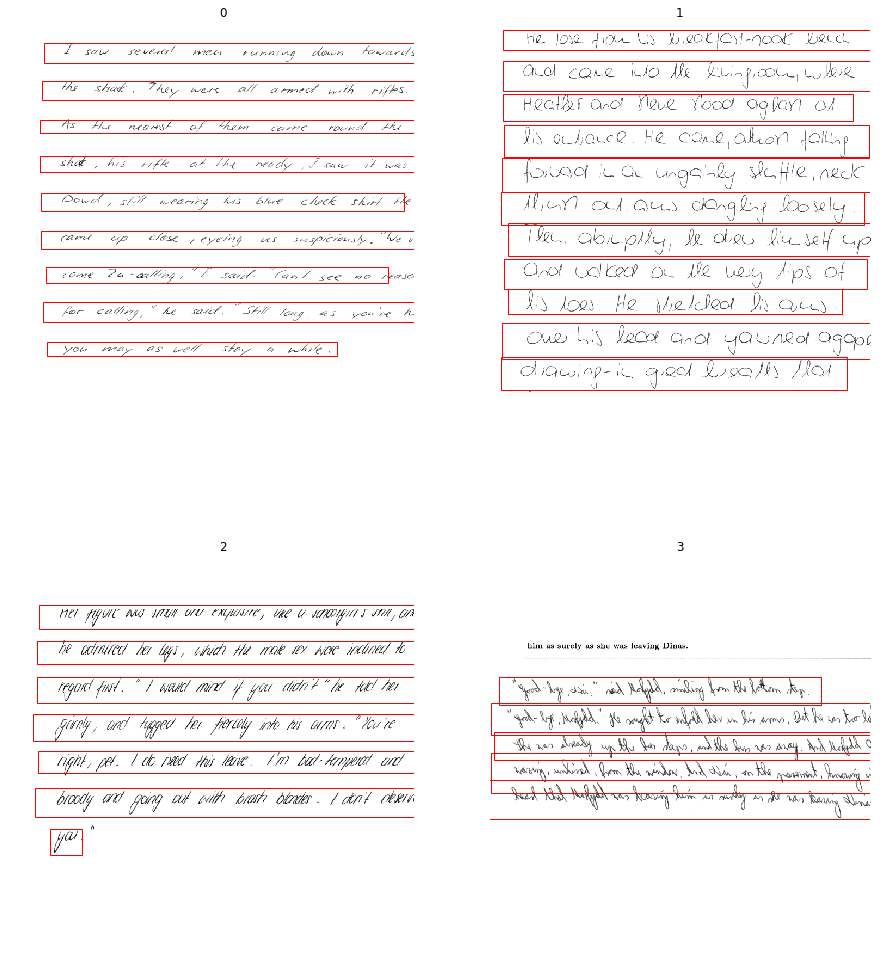

In [35]:
line_images_array = []
line_images_0=[]
line_images_1=[]
line_images_2=[]
line_images_3=[]
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    if(i==0):
        line_images_0.append(line_images)
    elif(i==1):
        line_images_1.append(line_images)
    elif(i==2):
        line_images_2.append(line_images)
    elif(i==3):
        line_images_3.append(line_images)
    
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

# 10. Load Handwriting Recognition Model

In [36]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [37]:
line_image_size = (60, 800)
character_probs = []
#for line_images in line_images_array:
total_line_images=[line_images_0,line_images_1,line_images_2,line_images_3]
for line_images in line_images_0:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

In [38]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [39]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

# 11. Run Handwriting Recognition on test images

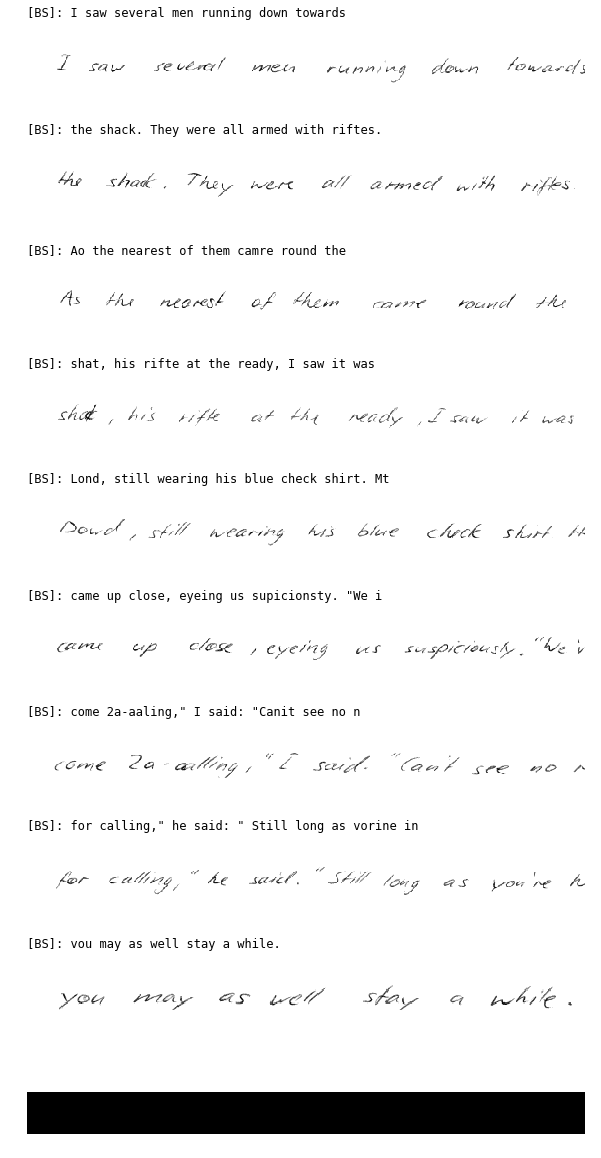

In [40]:
final_decoded=[]
final_text=""
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_bs = get_beam_search(line_character_probs)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[BS]: {}\n\n".format(decoded_line_bs), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
        #final_decoded.append(decoded_line_bs)
        final_text=final_text+" "+decoded_line_bs
        
        
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# 12. Compare prediction with Human Insight

 I saw several men running down towards the shack. They were all armed with riftes. Ao the nearest of them camre round the shat, his rifte at the ready, I saw it was Lond, still wearing his blue check shirt. Mt came up close, eyeing us supicionsty. "We i come 2a-aaling," I said: "Canit see no n for calling," he said: " Still long as vorine in vou may as well stay a while.


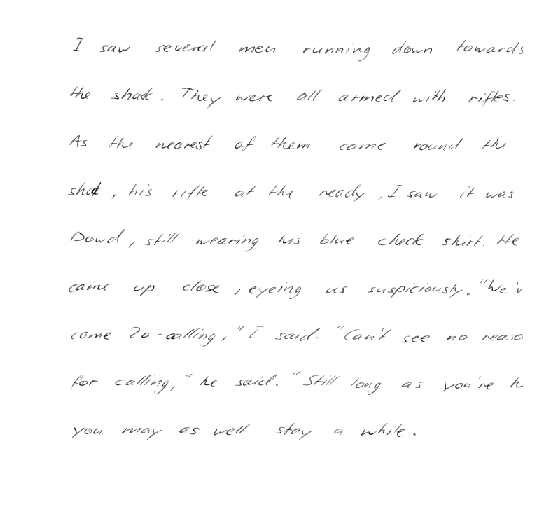

In [41]:
plt.figure(figsize=(30,9))
plt.imshow(final_image,cmap='Greys_r')
plt.axis('off')
print(final_text)